In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import datetime
import itertools
import os
from contextlib import redirect_stdout
from tqdm.notebook import tqdm
import pickle

In [2]:
rand = 64
lgb_params = {
    "objective": "binary",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 20,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.001,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 100,
    "lambda_l1": 0,
    "lambda_l2": 0,
    "random_state": rand,
    "metric": "auc",#"binary_logloss",
    "verbose": -1
}


In [3]:
tran_dtypes = {"t_dat":"str",
               "customer_id":"str",
               "article_id":"int",
               "product_code":"int",
               "price":"float",
               "sales_channel_id":"int"}
art_dtypes = {"article_id":"int",
              "product_code":"int",
              "product_type_no":"int",
              "graphical_appearance_no":"int",
              "colour_group_code":"int",
              "department_no":"int",
              "index_code":"str",
              "index_group_no":"int",
              "section_no":"int",
              "garment_group_no":"int"}
cust_dtypes = {"customer_id":"str"}

obj = "class" # "class" or "rank"
N = 1000
n_iter = 1 # num of iteration
idx_file = "exp05"
len_hist = 90
n_round = 20
n_splits = 1
tr_set = [1] # set of train date
len_tr = 7 # length of validation period
nobuy = 5 # num of negative samples

In [4]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [5]:
def read_data(day_oldest):
    filehandler = open("article_list.pkl", "rb")
    article_list = pickle.load(filehandler)
    filehandler.close()
    
    filehandler = open("customer_list.pkl", "rb")
    customer_list = pickle.load(filehandler)
    filehandler.close()
    
    df_art = pd.read_csv("articles.csv",dtype=art_dtypes)
    filehandler = open("article_list.pkl", "rb")
    article_list = pickle.load(filehandler)
    filehandler.close()
    df_art = df_art.loc[df_art.article_id.isin(article_list),:].reset_index()
    
    le = LabelEncoder()
    le.fit(df_art["index_code"].unique())
    df_art["index_code"] = le.transform(df_art["index_code"])

    filehandler = open("transactions_6mth.pkl", "rb")
    df_trans = pickle.load(filehandler)
    filehandler.close()
    #df_trans["t_dat"] = pd.to_datetime(df_trans["t_dat"],format="%Y-%m-%d")

    df_trans = df_trans.query(f"t_dat >= '{day_oldest}'").copy()
    df_trans = df_trans.drop_duplicates(["customer_id","article_id","t_dat"])
    df_trans = df_trans.merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")

    df_cust = pd.read_csv("customers.csv",dtype=cust_dtypes)
    df_cust = df_cust.loc[df_cust.customer_id.isin(customer_list),:].reset_index()
    df_cust["age"] = df_cust["age"].fillna(df_cust["age"].mean())
    df_cust[["FN","Active"]] = df_cust[["FN","Active"]].fillna(0)
    df_cust["club_member_status"] = df_cust["club_member_status"].apply(lambda x:1 if x == "ACTIVE" else 0)
    df_cust["fashion_news_frequency"] = df_cust["fashion_news_frequency"].apply(lambda x:0 if x == "NONE" else 1)
    
    dict_vec = {}
    vec_art = np.load("articles.npy")
    df_vec = pd.concat([df_art["article_id"],pd.DataFrame(vec_art)],axis=1)
    for i in range(len(vec_art)):
        dict_vec[df_art["article_id"][i]] = vec_art[i]
    del vec_art,df_vec
    

    return df_trans,df_art,df_cust, dict_vec

In [6]:
def feat_store(df_trans,l_cust,ds,de,dsr,der,dsh,deh):
    feat ={}

    df_trans_yesterday = df_trans.query("(t_dat == @der)")
    df_trans_recent = df_trans.query("(t_dat >= @dsr) and (t_dat <= @der)")
    df_trans_hist = df_trans.query("(t_dat >= @dsh) and (t_dat <= @deh)")

    feat["art_buy_hist"] = df_trans_hist.groupby(["article_id"])["t_dat"].agg(art_buy_hist="count")
    feat["art_buy_recent"] = df_trans_recent.groupby(["article_id"])["t_dat"].agg(art_buy_recent="count")
    feat["art_buy_yesterday"] = df_trans_yesterday.groupby(["article_id"])["t_dat"].agg(art_buy_yesterday="count")
    df_buy1 = df_trans_hist.groupby("article_id")["customer_id"].nunique().reset_index().rename(columns={"customer_id":"cnt_buy1"})
    df_buy2 = df_trans_hist[df_trans_hist.duplicated(["customer_id","article_id"])].copy()
    df_buy2 = df_buy2.drop_duplicates(["customer_id","article_id"])
    df_buy2 = df_buy2.groupby("article_id")["article_id"].agg(cnt_buy2='count').reset_index()
    df_buy = pd.merge(df_buy1,df_buy2,how="left",on="article_id").fillna(0)
    df_buy["rebuy_rate"] = df_buy["cnt_buy2"]/df_buy["cnt_buy1"]
    feat["rebuy_rate"] = df_buy[["article_id","rebuy_rate"]]

    df_trans_yesterday = df_trans_yesterday.query("(customer_id in @l_cust)")
    df_trans_recent = df_trans_recent.query("(customer_id in @l_cust)")
    df_trans_hist = df_trans_hist.query("(customer_id in @l_cust)")
    feat["rate_sales_channel_hist"] = df_trans_hist.groupby(["customer_id"])["sales_channel_id"].agg(rate_sales_channel_hist="mean")
    feat["rate_sales_channel_recent"] = df_trans_recent.groupby(["customer_id"])["sales_channel_id"].agg(rate_sales_channel_recent="mean")
    feat["n_buy_hist"] = df_trans_hist.groupby(["customer_id","article_id"])["t_dat"].agg(n_buy_hist="count")
    feat["n_buy_recent"] = df_trans_recent.groupby(["customer_id","article_id"])["t_dat"].agg(n_buy_recent="count")
    feat["days_after_buy"] = df_trans_hist.groupby(["customer_id","article_id"])["t_dat"].agg(days_after_buy=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_all"] = df_trans_hist.groupby(["customer_id"])["t_dat"].agg(n_buy_hist_all="count")
    feat["n_buy_recent_all"] = df_trans_recent.groupby(["customer_id"])["t_dat"].agg(n_buy_recent_all="count")
    feat["days_after_buy_all"] = df_trans_hist.groupby(["customer_id"])["t_dat"].agg(days_after_buy_all=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_prod"] = df_trans_hist.groupby(["customer_id","product_code"])["t_dat"].agg(n_buy_hist_prod="count")
    feat["n_buy_recent_prod"] = df_trans_recent.groupby(["customer_id","product_code"])["t_dat"].agg(n_buy_recent_prod="count")
    feat["days_after_buy_prod"] = df_trans_hist.groupby(["customer_id","product_code"])["t_dat"].agg(days_after_buy_prod=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_ptype"] = df_trans_hist.groupby(["customer_id","product_type_no"])["t_dat"].agg(n_buy_hist_ptype="count")
    feat["n_buy_recent_ptype"] = df_trans_recent.groupby(["customer_id","product_type_no"])["t_dat"].agg(n_buy_recent_ptype="count")
    feat["days_after_buy_ptype"] = df_trans_hist.groupby(["customer_id","product_type_no"])["t_dat"].agg(days_after_buy_ptype=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_graph"] = df_trans_hist.groupby(["customer_id","graphical_appearance_no"])["t_dat"].agg(n_buy_hist_graph="count")
    feat["n_buy_recent_graph"] = df_trans_recent.groupby(["customer_id","graphical_appearance_no"])["t_dat"].agg(n_buy_recent_graph="count")
    feat["days_after_buy_graph"] = df_trans_hist.groupby(["customer_id","graphical_appearance_no"])["t_dat"].agg(days_after_buy_graph=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_col"] = df_trans_hist.groupby(["customer_id","colour_group_code"])["t_dat"].agg(n_buy_hist_col="count")
    feat["n_buy_recent_col"] = df_trans_recent.groupby(["customer_id","colour_group_code"])["t_dat"].agg(n_buy_recent_col="count")
    feat["days_after_buy_col"] = df_trans_hist.groupby(["customer_id","colour_group_code"])["t_dat"].agg(days_after_buy_col=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_dep"] = df_trans_hist.groupby(["customer_id","department_no"])["t_dat"].agg(n_buy_hist_dep="count")
    feat["n_buy_recent_dep"] = df_trans_recent.groupby(["customer_id","department_no"])["t_dat"].agg(n_buy_recent_dep="count")
    feat["days_after_buy_dep"] = df_trans_hist.groupby(["customer_id","department_no"])["t_dat"].agg(days_after_buy_dep=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_idx"] = df_trans_hist.groupby(["customer_id","index_code"])["t_dat"].agg(n_buy_hist_idx="count")
    feat["n_buy_recent_idx"] = df_trans_recent.groupby(["customer_id","index_code"])["t_dat"].agg(n_buy_recent_idx="count")
    feat["days_after_buy_idx"] = df_trans_hist.groupby(["customer_id","index_code"])["t_dat"].agg(days_after_buy_idx=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_idxg"] = df_trans_hist.groupby(["customer_id","index_group_no"])["t_dat"].agg(n_buy_hist_idxg="count")
    feat["n_buy_recent_idxg"] = df_trans_recent.groupby(["customer_id","index_group_no"])["t_dat"].agg(n_buy_recent_idxg="count")
    feat["days_after_buy_idxg"] = df_trans_hist.groupby(["customer_id","index_group_no"])["t_dat"].agg(days_after_buy_idxg=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_sec"] = df_trans_hist.groupby(["customer_id","section_no"])["t_dat"].agg(n_buy_hist_sec="count")
    feat["n_buy_recent_sec"] = df_trans_recent.groupby(["customer_id","section_no"])["t_dat"].agg(n_buy_recent_sec="count")
    feat["days_after_buy_sec"] = df_trans_hist.groupby(["customer_id","section_no"])["t_dat"].agg(days_after_buy_sec=lambda x:(ds - max(x)).days)
    feat["n_buy_hist_garm"] = df_trans_hist.groupby(["customer_id","garment_group_no"])["t_dat"].agg(n_buy_hist_garm="count")
    feat["n_buy_recent_garm"] = df_trans_recent.groupby(["customer_id","garment_group_no"])["t_dat"].agg(n_buy_recent_garm="count")
    feat["days_after_buy_garm"] = df_trans_hist.groupby(["customer_id","garment_group_no"])["t_dat"].agg(days_after_buy_garm=lambda x:(ds - max(x)).days)
    feat["art_id_recent"] = df_trans_recent.groupby("customer_id")["article_id"].apply(list).rename("art_id_recent")

    del df_trans_yesterday, df_trans_recent, df_trans_hist, df_buy1, df_buy2, df_buy
    gc.collect()

    return feat

In [7]:
def add_feat(df,ds,de,dsr,der,dsh,deh,feat,dict_vec):
    # rate_sales_channel_hist
    df = df.merge(feat["rate_sales_channel_hist"],how="left",left_on=["customer_id"], right_index=True)
    # rate_sales_channel_recent
    df = df.merge(feat["rate_sales_channel_recent"],how="left",left_on=["customer_id"], right_index=True)  
    # art_buy_hist
    df = df.merge(feat["art_buy_hist"],how="left",left_on=["article_id"], right_index=True)
    # art_buy_recent
    df = df.merge(feat["art_buy_recent"],how="left",left_on=["article_id"], right_index=True)  
    # art_buy_yesterday
    df = df.merge(feat["art_buy_yesterday"],how="left",left_on=["article_id"], right_index=True)  
    # n_buy_hist
    df = df.merge(feat["n_buy_hist"],how="left",left_on=["customer_id","article_id"], right_index=True)
    # n_buy_recent
    df = df.merge(feat["n_buy_recent"],how="left",left_on=["customer_id","article_id"], right_index=True)
    # days_after_buy
    df = df.merge(feat["days_after_buy"],how="left",left_on=["customer_id","article_id"], right_index=True)
    # n_buy_hist_all
    df = df.merge(feat["n_buy_hist_all"],how="left",left_on=["customer_id"], right_index=True)
    # n_buy_recent_all
    df = df.merge(feat["n_buy_recent_all"],how="left",left_on=["customer_id"], right_index=True)
    # days_after_buy_all
    df = df.merge(feat["days_after_buy_all"],how="left",left_on=["customer_id"], right_index=True)
    # n_buy_hist_prod
    df = df.merge(feat["n_buy_hist_prod"],how="left",left_on=["customer_id","product_code"], right_index=True)
    # n_buy_recent_prod
    df = df.merge(feat["n_buy_recent_prod"],how="left",left_on=["customer_id","product_code"], right_index=True)
    # days_after_buy_prod
    df = df.merge(feat["days_after_buy_prod"],how="left",left_on=["customer_id","product_code"], right_index=True)
    # n_buy_hist_ptype
    df = df.merge(feat["n_buy_hist_ptype"],how="left",left_on=["customer_id","product_type_no"], right_index=True)
    # n_buy_recent_ptype
    df = df.merge(feat["n_buy_recent_ptype"],how="left",left_on=["customer_id","product_type_no"], right_index=True)
    # days_after_buy_ptype
    df = df.merge(feat["days_after_buy_ptype"],how="left",left_on=["customer_id","product_type_no"], right_index=True)
    # n_buy_hist_graph
    df = df.merge(feat["n_buy_hist_graph"],how="left",left_on=["customer_id","graphical_appearance_no"], right_index=True)
    # n_buy_recent_graph
    df = df.merge(feat["n_buy_recent_graph"],how="left",left_on=["customer_id","graphical_appearance_no"], right_index=True)
    # days_after_buy_graph
    df = df.merge(feat["days_after_buy_graph"],how="left",left_on=["customer_id","graphical_appearance_no"], right_index=True)
    # n_buy_hist_col
    df = df.merge(feat["n_buy_hist_col"],how="left",left_on=["customer_id","colour_group_code"], right_index=True)
    # n_buy_recent_col
    df = df.merge(feat["n_buy_recent_col"],how="left",left_on=["customer_id","colour_group_code"], right_index=True)
    # days_after_buy_col
    df = df.merge(feat["days_after_buy_col"],how="left",left_on=["customer_id","colour_group_code"], right_index=True)
    # n_buy_hist_dep
    df = df.merge(feat["n_buy_hist_dep"],how="left",left_on=["customer_id","department_no"], right_index=True)
    # n_buy_recent_dep
    df = df.merge(feat["n_buy_recent_dep"],how="left",left_on=["customer_id","department_no"], right_index=True)
    # days_after_buy_dep
    df = df.merge(feat["days_after_buy_dep"],how="left",left_on=["customer_id","department_no"], right_index=True)
    # n_buy_hist_idx
    df = df.merge(feat["n_buy_hist_idx"],how="left",left_on=["customer_id","index_code"], right_index=True)
    # n_buy_recent_idx
    df = df.merge(feat["n_buy_recent_idx"],how="left",left_on=["customer_id","index_code"], right_index=True)
    # days_after_buy_idx
    df = df.merge(feat["days_after_buy_idx"],how="left",left_on=["customer_id","index_code"], right_index=True)
    # n_buy_hist_idxg
    df = df.merge(feat["n_buy_hist_idxg"],how="left",left_on=["customer_id","index_group_no"], right_index=True)
    # n_buy_recent_idxg
    df = df.merge(feat["n_buy_recent_idxg"],how="left",left_on=["customer_id","index_group_no"], right_index=True)
    # days_after_buy_idxg
    df = df.merge(feat["days_after_buy_idxg"],how="left",left_on=["customer_id","index_group_no"], right_index=True)
    # n_buy_hist_sec
    df = df.merge(feat["n_buy_hist_sec"],how="left",left_on=["customer_id","section_no"], right_index=True)
    # n_buy_recent_sec
    df = df.merge(feat["n_buy_recent_sec"],how="left",left_on=["customer_id","section_no"], right_index=True)
    # days_after_buy_sec
    df = df.merge(feat["days_after_buy_sec"],how="left",left_on=["customer_id","section_no"], right_index=True)
    # n_buy_hist_garm
    df = df.merge(feat["n_buy_hist_garm"],how="left",left_on=["customer_id","garment_group_no"], right_index=True)
    # n_buy_recent_garm
    df = df.merge(feat["n_buy_recent_garm"],how="left",left_on=["customer_id","garment_group_no"], right_index=True)
    # days_after_buy_garm
    df = df.merge(feat["days_after_buy_garm"],how="left",left_on=["customer_id","garment_group_no"], right_index=True)
    # rebuy_rate
    df = df.merge(feat["rebuy_rate"],how="left",on="article_id")
    # sim_article
    df = df.merge(feat["art_id_recent"],how="left",left_on="customer_id", right_index = True)

    sim_max,sim_sum,sim_mean = [],[],[]
    # display(df[["article_id","art_id_recent"]].head())
    tmp = df[["article_id","art_id_recent"]].values
    for i in range(len(df)):
        if not isinstance(tmp[i][1],list):
            sim_max.append(0);sim_sum.append(0);sim_mean.append(0)
        else:
            list_sim = [cos_sim(dict_vec[tmp[i][0]],dict_vec[x]) for x in tmp[i][1]]
            sim_max.append(max(list_sim))
            sim_sum.append(sum(list_sim))
            sim_mean.append(np.mean(list_sim))
    df["sim_max"] = sim_max
    df["sim_sum"] = sim_sum
    df["sim_mean"] = sim_mean

    df = df.drop(["art_id_recent"], axis = 1)
    # fillna
    df[["n_buy_hist","n_buy_recent","n_buy_hist_all","n_buy_recent_all","n_buy_hist_prod","n_buy_recent_prod","n_buy_hist_ptype","n_buy_recent_ptype","n_buy_hist_graph","n_buy_recent_graph",
      "n_buy_hist_col","n_buy_recent_col","n_buy_hist_dep","n_buy_recent_dep","n_buy_hist_idx","n_buy_recent_idx","n_buy_hist_idxg","n_buy_recent_idxg","n_buy_hist_sec","n_buy_recent_sec",
      "n_buy_hist_garm","n_buy_recent_garm","art_buy_yesterday","art_buy_recent","art_buy_hist","rebuy_rate", "sim_max", "sim_sum", "sim_mean"]] =\
    df[["n_buy_hist","n_buy_recent","n_buy_hist_all","n_buy_recent_all","n_buy_hist_prod","n_buy_recent_prod","n_buy_hist_ptype","n_buy_recent_ptype","n_buy_hist_graph","n_buy_recent_graph",
      "n_buy_hist_col","n_buy_recent_col","n_buy_hist_dep","n_buy_recent_dep","n_buy_hist_idx","n_buy_recent_idx","n_buy_hist_idxg","n_buy_recent_idxg","n_buy_hist_sec","n_buy_recent_sec",
      "n_buy_hist_garm","n_buy_recent_garm","art_buy_yesterday","art_buy_recent","art_buy_hist","rebuy_rate", "sim_max", "sim_sum", "sim_mean"]].fillna(0)

    df[["days_after_buy","days_after_buy_all","days_after_buy_prod","days_after_buy_ptype","days_after_buy_graph","days_after_buy_col","days_after_buy_dep","days_after_buy_idx",
      "days_after_buy_idxg","days_after_buy_sec","days_after_buy_garm"]] = \
    df[["days_after_buy","days_after_buy_all","days_after_buy_prod","days_after_buy_ptype","days_after_buy_graph","days_after_buy_col","days_after_buy_dep","days_after_buy_idx",
      "days_after_buy_idxg","days_after_buy_sec","days_after_buy_garm"]].fillna(10+len_hist)

    df[["rate_sales_channel_hist","rate_sales_channel_recent"]] = df[["rate_sales_channel_hist","rate_sales_channel_recent"]].fillna(1.5)

    return df

In [8]:
def recommend_train(day_start_val):
    day_start = [day_start_val - datetime.timedelta(days=i-1+len_tr) for i in tr_set]
    day_end = [day_start_val - datetime.timedelta(days=i) for i in tr_set]
    day_start_rec = [x - datetime.timedelta(days=7) for x in day_start]
    day_end_rec = [x - datetime.timedelta(days=1) for x in day_start]
    day_start_hist = [x - datetime.timedelta(days=len_hist) for x in day_start]
    day_end_hist = [x - datetime.timedelta(days=1) for x in day_start]
    day_start_rec_test = day_start_val - datetime.timedelta(days=7)
    day_end_rec_test = day_start_val - datetime.timedelta(days=1)
    day_start_hist_test = day_start_val - datetime.timedelta(days=1+len_hist)
    day_end_hist_test = day_start_val - datetime.timedelta(days=1)
    day_end_val = day_start_val + datetime.timedelta(days=6)

    df_trans, df_art, df_cust, dict_vec = read_data(day_oldest = day_start_hist[-1])

    q_date = ""
    for i in range(len(day_start)):
        if i == 0: q_date = f"((t_dat >= '{day_start[0]}') and (t_dat <= '{day_end[0]}'))"
        else: q_date = q_date + f" or ((t_dat >= '{day_start[i]}') and (t_dat <= '{day_end[i]}'))"
    top_art_all = df_trans.query(q_date).groupby("article_id")["t_dat"].count().sort_values(ascending = False).index[:N].tolist()

    list_df_buy = []
    list_list_cust =[]
    # make posivive samples
        for i in range(len(day_start)):
        list_df_buy.append(df_trans.query(f"(t_dat >= '{day_start[i]}') and (t_dat <= '{day_end[i]}') and (article_id in @top_art_all)").drop_duplicates(["customer_id","article_id"])[["customer_id","article_id"]].copy())
        list_df_buy[i]["target"] = 1
        list_list_cust.append(list_df_buy[i]["customer_id"].unique().tolist()) 
    # make negative samples(random pick)
    for iter_train in tqdm(range(n_iter)):
        list_df_nobuy = []
        list_train =[]
        for i in range(len(day_start)):
            list_df_nobuy.append(pd.concat([pd.DataFrame({"customer_id":x,"article_id":random.sample(top_art_all,nobuy)}) for x in list_list_cust[i]]))
            list_df_nobuy[i]["target"] = 0
            list_train.append(pd.concat([list_df_buy[i],list_df_nobuy[i]]).drop_duplicates(["customer_id","article_id"]))
        del list_df_nobuy
        display(list_train[0]["target"].value_counts())

        # add feature
        df_train = pd.DataFrame()
        for i in tqdm(range(len(day_start))):
            feat = feat_store(df_trans,list_list_cust[i],day_start[i],day_end[i],day_start_rec[i],day_end_rec[i],day_start_hist[i],day_end_hist[i])
            list_train[i] = list_train[i].merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")
            list_train[i] = list_train[i].merge(df_cust[["customer_id","age","FN","Active","club_member_status","fashion_news_frequency"]],how="left",on="customer_id")
            df_train = df_train.append(add_feat(list_train[i],day_start[i],day_end[i],day_start_rec[i],day_end_rec[i],day_start_hist[i],day_end_hist[i],feat,dict_vec))
            del feat
        del list_train
        gc.collect()
        '''
        # train lgbm
        X_train = df_train.drop(["customer_id","product_code","product_type_no","department_no","target"],axis=1)
        y_train = df_train["target"]
        #del df_train

        list_model = []
        if n_splits == 1:
            X_tr, X_va, y_tr, y_va = train_test_split(X_train,y_train,stratify = y_train)
            d_tr = lgb.Dataset(X_tr, label=y_tr,  free_raw_data=False)
            d_va = lgb.Dataset(X_va, label=y_va,  free_raw_data=False)
            list_model.append(lgb.train(lgb_params, train_set=d_tr, num_boost_round=n_round, valid_sets=[d_tr,d_va], verbose_eval=500, early_stopping_rounds=100))
        else:
            folds = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = rand)
            for tr_idx,va_idx in folds.split(X_train,y_train):
                X_tr, X_va, y_tr, y_va = X_train.iloc[tr_idx], X_train.iloc[va_idx], y_train.iloc[tr_idx], y_train.iloc[va_idx] 
                d_tr = lgb.Dataset(X_tr, label=y_tr,  free_raw_data=False)
                d_va = lgb.Dataset(X_va, label=y_va,  free_raw_data=False)
                list_model.append(lgb.train(lgb_params, train_set=d_tr, num_boost_round=n_round, valid_sets=[d_tr,d_va], verbose_eval=500, early_stopping_rounds=100))
        # save model
        pd.to_pickle(list_model,f"models_{iter_train}.pkl")
        del X_train, y_train, X_tr, X_va, y_tr, y_va, d_tr, d_va
        gc.collect()
        '''
    del df_trans, df_art, df_cust
    gc.collect()
    return df_train

IndentationError: unexpected indent (Temp/ipykernel_16864/1308440652.py, line 25)

In [9]:
#df_train = recommend_train(datetime.datetime(2020,9,23))
import time

In [11]:
# Create the training data
start = time.perf_counter()

day_start_val = datetime.datetime(2020,9,16)
day_start = [day_start_val - datetime.timedelta(days=i-1+len_tr) for i in tr_set]
day_end = [day_start_val - datetime.timedelta(days=i) for i in tr_set]
day_start_rec = [x - datetime.timedelta(days=7) for x in day_start]
day_end_rec = [x - datetime.timedelta(days=1) for x in day_start]
day_start_hist = [x - datetime.timedelta(days=len_hist) for x in day_start]
day_end_hist = [x - datetime.timedelta(days=1) for x in day_start]
day_start_rec_test = day_start_val - datetime.timedelta(days=7)
day_end_rec_test = day_start_val - datetime.timedelta(days=1)
day_start_hist_test = day_start_val - datetime.timedelta(days=1+len_hist)
day_end_hist_test = day_start_val - datetime.timedelta(days=1)
day_end_val = day_start_val + datetime.timedelta(days=6)

df_trans, df_art, df_cust, dict_vec = read_data(day_oldest = day_start_hist[-1])
print(day_start)
print(day_end)
print(day_start_rec)
print(day_end_rec)

print("import ", time.perf_counter()-start)

q_date = ""
for i in range(len(day_start)):
    if i == 0: q_date = f"((t_dat >= '{day_start[0]}') and (t_dat <= '{day_end[0]}'))"
    else: q_date = q_date + f" or ((t_dat >= '{day_start[i]}') and (t_dat <= '{day_end[i]}'))"
top_art_all = df_trans.query(q_date).groupby("article_id")["t_dat"].count().sort_values(ascending = False).index[:N].tolist()
print("top_art ", time.perf_counter()-start)
list_df_buy = []
list_list_cust =[]
# make posivive samples
for i in range(len(day_start)):
    list_df_buy.append(df_trans.query(f"(t_dat >= '{day_start[i]}') and (t_dat <= '{day_end[i]}') and (article_id in @top_art_all)").drop_duplicates(["customer_id","article_id"])[["customer_id","article_id"]].copy())
    list_df_buy[i]["target"] = 1
    list_list_cust.append(list_df_buy[i]["customer_id"].unique().tolist()) 
# make negative samples(random pick)
for iter_train in tqdm(range(n_iter)):
    list_df_nobuy = []
    list_train =[]
    for i in range(len(day_start)):
        list_df_nobuy.append(pd.concat([pd.DataFrame({"customer_id":x,"article_id":random.sample(top_art_all,nobuy)}) for x in list_list_cust[i]]))
        list_df_nobuy[i]["target"] = 0
        list_train.append(pd.concat([list_df_buy[i],list_df_nobuy[i]]).drop_duplicates(["customer_id","article_id"]))
    del list_df_nobuy
    display(list_train[0]["target"].value_counts())
    print("make_samples ", time.perf_counter()-start)
    # add feature
    df_train = pd.DataFrame()
    for i in tqdm(range(len(day_start))):
        feat = feat_store(df_trans,list_list_cust[i],day_start[i],day_end[i],day_start_rec[i],day_end_rec[i],day_start_hist[i],day_end_hist[i])
        list_train[i] = list_train[i].merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")
        list_train[i] = list_train[i].merge(df_cust[["customer_id","age","FN","Active","club_member_status","fashion_news_frequency"]],how="left",on="customer_id")
        df_train = df_train.append(add_feat(list_train[i],day_start[i],day_end[i],day_start_rec[i],day_end_rec[i],day_start_hist[i],day_end_hist[i],feat,dict_vec))
        del feat
    del list_train
    gc.collect()

print("final ", time.perf_counter()-start)


[datetime.datetime(2020, 9, 9, 0, 0)]
[datetime.datetime(2020, 9, 15, 0, 0)]
[datetime.datetime(2020, 9, 2, 0, 0)]
[datetime.datetime(2020, 9, 8, 0, 0)]
import  5.1440585
top_art  5.163664999999995


  0%|          | 0/1 [00:00<?, ?it/s]

0    44208
1    22031
Name: target, dtype: int64

make_samples  9.641031999999996


  0%|          | 0/1 [00:00<?, ?it/s]

final  43.373571


In [11]:
rand = 64
lgb_params = {
    "objective": "binary",
    "boosting": "gbdt",
    "max_depth": 3,
    "num_leaves": 8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.4,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 600,
    "lambda_l1": 0,
    "lambda_l2": 0,
    "random_state": rand,
    "metric": "auc",#"binary_logloss",
    "verbose": -1
}

n_round = 1000

In [12]:
    
# train lgbm
X_train = df_train.drop(["customer_id","product_code","product_type_no","department_no","target","article_id"],axis=1)
y_train = df_train["target"]
#del df_train


if n_splits == 1:
    X_tr, X_va, y_tr, y_va = train_test_split(X_train,y_train,stratify = y_train)
    d_tr = lgb.Dataset(X_tr, label=y_tr,  free_raw_data=False)
    d_va = lgb.Dataset(X_va, label=y_va,  free_raw_data=False)
    lgb_model = lgb.train(lgb_params, train_set=d_tr, num_boost_round=n_round, valid_sets=[d_tr,d_va], callbacks=[lgb.early_stopping(stopping_rounds=100)] )

# save model
pd.to_pickle(lgb_model,f"models_{iter_train}.pkl")
del X_train, y_train, X_tr, X_va, y_tr, y_va, d_tr, d_va
gc.collect()


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[503]	training's auc: 0.765486	valid_1's auc: 0.702695


457

In [62]:
lgb_model = pd.read_pickle("models_0.pkl")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

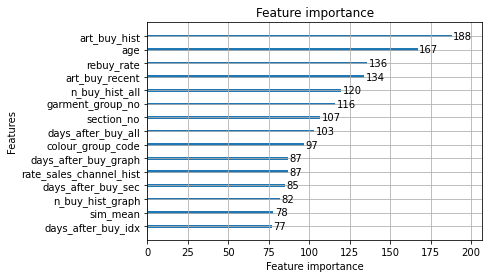

In [64]:
lgb.plot_importance(lgb_model, max_num_features = 15)

In [50]:
art_buy_table = pd.crosstab(df_train.art_buy_hist, df_train.target, normalize = 'index')
art_buy_table.columns = ['target_0', 'target_1']
art_buy_table

,target_0,target_1
art_buy_hist,,
0.0,0.677360,0.322640
1.0,0.683005,0.316995
2.0,0.702518,0.297482
3.0,0.673048,0.326952
4.0,0.695268,0.304732
...,...,...
169.0,0.345865,0.654135
172.0,0.489130,0.510870
180.0,0.381818,0.618182


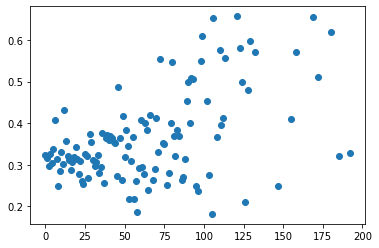

In [51]:
import matplotlib

matplotlib.pyplot.scatter(art_buy_table.index, art_buy_table.target_1)

In [10]:
obj = "class" # "class" or "rank"
N = 1000
n_iter = 1 # num of iteration
idx_file = "exp05"
len_hist = 90
n_round = 20
n_splits = 1
tr_set = [1] # set of train date
len_tr = 7 # length of validation period
nobuy = 5 # num of negative samples

In [25]:
# create testing data
start = time.perf_counter()

day_start_val = datetime.datetime(2020,9,23)
day_start = [day_start_val - datetime.timedelta(days=i-1+len_tr) for i in tr_set]
day_end = [day_start_val - datetime.timedelta(days=i) for i in tr_set]
day_start_rec = [x - datetime.timedelta(days=7) for x in day_start]
day_end_rec = [x - datetime.timedelta(days=1) for x in day_start]
day_start_hist = [x - datetime.timedelta(days=len_hist) for x in day_start]
day_end_hist = [x - datetime.timedelta(days=1) for x in day_start]
day_start_rec_test = day_start_val - datetime.timedelta(days=7)
day_end_rec_test = day_start_val - datetime.timedelta(days=1)
day_start_hist_test = day_start_val - datetime.timedelta(days=1+len_hist)
day_end_hist_test = day_start_val - datetime.timedelta(days=1)
day_end_val = day_start_val + datetime.timedelta(days=6)

df_trans, df_art, df_cust, dict_vec = read_data(day_oldest = day_start_hist[-1])
print(day_start)
print(day_end)
print(day_start_rec)
print(day_end_rec)
print("import ", time.perf_counter()-start)

q_date = ""
q_date = f"((t_dat >= '{day_start_rec[0]}') and (t_dat <= '{day_end_rec[0]}'))"
top_art_all = df_trans.query(q_date).groupby("article_id")["t_dat"].count().sort_values(ascending = False).index[:N].tolist()
print("top_art ", time.perf_counter()-start)
# Fake transations
customer_array = np.repeat(df_trans.customer_id.unique(), N)
article_array = np.tile(top_art_all, len(df_trans.customer_id.unique()))
df_setup = pd.DataFrame({'customer_id':customer_array, 'article_id':article_array})

print("fake trans ", time.perf_counter()-start)

list_df_buy = []
list_list_cust =[]
# make posivive samples
for i in range(len(day_start)):
    list_df_buy.append(df_setup)
    list_df_buy[i]["target"] = 1
    list_list_cust.append(list_df_buy[i]["customer_id"].unique().tolist()) 
# make negative samples(random pick)
for iter_train in tqdm(range(n_iter)):
    list_train =[]
    for i in range(len(day_start)):
        list_train.append(list_df_buy[i])
        print("make samples ", time.perf_counter()-start)
    # add feature
    df_test = pd.DataFrame()
    for i in tqdm(range(len(day_start))):
        feat = feat_store(df_trans,list_list_cust[i],day_start[i],day_end[i],day_start_rec[i],day_end_rec[i],day_start_hist[i],day_end_hist[i])
        list_train[i] = list_train[i].merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")
        list_train[i] = list_train[i].merge(df_cust[["customer_id","age","FN","Active","club_member_status","fashion_news_frequency"]],how="left",on="customer_id")
        df_test = df_test.append(add_feat(list_train[i],day_start[i],day_end[i],day_start_rec[i],day_end_rec[i],day_start_hist[i],day_end_hist[i],feat,dict_vec))
        del feat
    del list_train
    gc.collect()
'''
# add feature
df_train = pd.DataFrame()
feat = feat_store(df_trans,list_list_cust,day_start,day_end,day_start_rec,day_end_rec,day_start_hist,day_end_hist)
list_train = list_train.merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")
list_train = list_train.merge(df_cust[["customer_id","age","FN","Active","club_member_status","fashion_news_frequency"]],how="left",on="customer_id")
df_test = df_test.append(add_feat(list_train,day_start,day_end,day_start_rec,day_end_rec,day_start_hist,day_end_hist,feat,dict_vec))
del feat
del list_train

gc.collect()
'''

print("final ", time.perf_counter()-start)

[datetime.datetime(2020, 9, 16, 0, 0)]
[datetime.datetime(2020, 9, 22, 0, 0)]
[datetime.datetime(2020, 9, 9, 0, 0)]
[datetime.datetime(2020, 9, 15, 0, 0)]
import  3.3901323999999704
top_art  3.4067053999999644
fake trans  3.484992699999907


  0%|          | 0/1 [00:00<?, ?it/s]

make samples  3.529057099999932


  0%|          | 0/1 [00:00<?, ?it/s]

final  70.51424799999995


In [12]:
df_test

,customer_id,article_id,target,product_code,product_type_no,graphical_appearance_no,colour_group_code,department_no,index_code,index_group_no,...,n_buy_hist_sec,n_buy_recent_sec,days_after_buy_sec,n_buy_hist_garm,n_buy_recent_garm,days_after_buy_garm,rebuy_rate,sim_max,sim_sum,sim_mean
0,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,909370001,1,909370,265,1010022,11,3090,0,1,...,17.0,1.0,7.0,0.0,0.0,100.0,0.047101,0.317201,0.530486,0.176829
1,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,924243001,1,924243,252,1010016,13,1626,0,1,...,17.0,1.0,7.0,0.0,0.0,100.0,0.021622,0.317208,0.431027,0.143676
2,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,918522001,1,918522,252,1010016,11,1626,0,1,...,17.0,1.0,7.0,0.0,0.0,100.0,0.019231,0.317879,0.422794,0.140931
3,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,865799006,1,865799,272,1010016,12,1722,0,1,...,17.0,1.0,7.0,6.0,0.0,18.0,0.027972,0.313393,0.418845,0.139615
4,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,910601003,1,910601,272,1010018,13,1722,0,1,...,17.0,1.0,7.0,6.0,0.0,18.0,0.125000,0.205984,0.205863,0.068621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117645,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,809238001,1,809238,252,1010016,9,1647,3,2,...,0.0,0.0,100.0,0.0,0.0,100.0,0.000000,0.000000,0.000000,0.000000
117646,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,923758001,1,923758,-1,1010016,10,1522,0,1,...,0.0,0.0,100.0,0.0,0.0,100.0,0.019231,0.000000,0.000000,0.000000
117647,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,762846027,1,762846,259,1010016,13,1515,0,1,...,0.0,0.0,100.0,0.0,0.0,100.0,0.099099,0.000000,0.000000,0.000000
117648,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,924243002,1,924243,252,1010016,9,1626,0,1,...,0.0,0.0,100.0,0.0,0.0,100.0,0.010417,0.000000,0.000000,0.000000


In [14]:
lgb_model = pd.read_pickle("models_0.pkl")

In [29]:
X_test = df_test.drop(["customer_id","product_code","product_type_no","department_no","target","article_id"],axis=1)
ypred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
eval_df = pd.concat([df_test['customer_id'], df_test['article_id'], pd.Series(ypred)], axis=1)

In [32]:
eval_df.columns = ["customer_id", "article_id", "pred"]
eval_df

,customer_id,article_id,pred
0,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,909370001,0.833160
1,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,924243001,0.579457
2,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,918522001,0.429124
3,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,865799006,0.469135
4,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,910601003,0.585803
...,...,...,...
117645,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,809238001,0.573520
117646,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,923758001,0.728540
117647,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,762846027,0.861684
117648,d61c3d3dd81f8bab59c7ac9c811fcda07bf889342b005c...,924243002,0.522299


In [34]:
eval_df = eval_df.sort_values(by = ["customer_id", "pred"], ascending = False)
eval_df

,customer_id,article_id,pred
30774,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,910601003,0.946123
30770,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,909370001,0.898168
30772,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,918522001,0.614685
30779,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,863646001,0.606349
30771,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,924243001,0.541676
...,...,...,...
38313,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,865799006,0.425135
38311,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,924243001,0.396399
38318,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,924243002,0.380333
38312,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,918522001,0.339952


In [53]:
article_rec = eval_df.groupby("customer_id").article_id.apply(list)
rec_dict = article_rec.to_dict()
rec_dict['0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4672f30b3e622fec55']

[809238001,
 909370001,
 910601003,
 863646001,
 762846027,
 865799006,
 924243001,
 924243002,
 918522001,
 923758001]

In [54]:
# Start validation

filehandler = open("transactions_6mth.pkl", "rb")
transactions_6mth = pickle.load(filehandler)
filehandler.close()
transactions_6mth

test = transactions_6mth.loc[transactions_6mth.t_dat >= '2020-09-16',:]

In [55]:
def calc_cust_precision(u_id):
    ground_truth = cust_orders[u_id]
    hits_list = (np.isin(rec_dict[u_id], ground_truth))*1
    ap = 0 ## average precision
    hits = np.sum(hits_list)
    relevant_n = len(ground_truth)

    if (hits != 0):
        for rank in range(1,len(hits_list)+1):
            # update ap on hit items
            hit = hits_list[rank-1]
            if hit:
                rank_hit_list = hits_list[0:rank]
                prec_i = np.mean(rank_hit_list)
                ap += prec_i  
        ap /= (min(relevant_n, 12))
    
    return ap

In [57]:
cust_orders = test.groupby("customer_id")["article_id"].unique()

In [59]:
customer_list = test.customer_id.unique()
ap_u = 0.

for u_id in customer_list:
    ap_u += calc_cust_precision(u_id)
mean_ap = ap_u / len(customer_list) 

In [1]:
#mean_ap

In [ ]:
sum_ap_500_700 = mean_ap*len(customer_list)
#total

filehandler = open("sum_ap_500_700", 'wb') 
pickle.dump(sum_ap_500_700, filehandler)
filehandler.close()

In [36]:
eval_df.customer_id.unique()

array(['fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20e02ce5d1e58a8f700b',
       'fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde2189bdd644f59071dd',
       'fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e593881ae6007d775f0f',
       ...,
       '00077dbd5c4a4991e092e63893ccf29294a9d5c46e85010e95f2fc10bf9437a4',
       '000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed6396773839f6bf71a9',
       '0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4672f30b3e622fec55'],
      dtype=object)